# Conversion Rate

### Goal

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.

The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and ﬁx it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve revenue.

This challenge is signiﬁcantly easier than all others in this collection. There are no dates, no tables to join, no feature engineering required, and the problem is really straightforward. Therefore, it is a great starting point to get familiar with data science take-home challenges.

**You should not move to the other challenges until you fully understand this one.**

---

### Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:
* Predict conversion rate
* Come up with recommendations for the product team and the marketing team to improve conversion rate

### Data

We have 1 table downloadable by clicking [here](https://gitee.com/SCILAB/data-science-take-home-challenegs).

> The table is "conversion_data". It has information about signed-in users during one session. Each row is a user session.

##### Columns:

* **country** : user country based on the IP address 
* **age** : user age. Self-reported at sign-in step 
* **new_user** : whether the user created the account during this session or had already an account and simply came back to the site 
* **source** : marketing channel source
    * Ads: came to the site by clicking on an advertisement
    * Seo: came to the site by clicking on search results
    * Direct: came to the site by directly typing the URL on the browser
* **total_pages_visited**: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
* **converted**: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

### Example

> Let's now check the characteristics of the user in the first row.

##### head(conversion_data, 1)
    
| **Field** | **Value** | **Description** |
|:---:|---|:---:|
| country | UK | the user is based in the UK |
| age | 25 | the user is 25 yr old |
| new_user | 1 | she created her account during this session |
| source | Ads | she came to the site by clicking on an ad |
| total_pages_visited | 1 | she visited just 1 page during that session |
| converted | 0 | this user did not buy during this session. These are the users whose behavior we want to change! |


# 目录

* [载入&理解数据](#load-and-inspect-data)
* [清洗数据](#clean-data)
* [数据预处理](#data-preprocessing)
* [机器学习](#machine-learning)
* [结论](#conclusion)

In [1]:
%pylab inline
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set() # seaborn 0.8 之前直接import即可覆盖plt样式，0.8之后需要显式设置

### load and inspect data

在做`machine learning`之前，要先`inspect data`。通常数据集里会包含错误数据、或者直接缺失数据。定位并清理错误数据是整个数据分析的第一步。

In [3]:
dataset = pd.read_csv("conversion_data.csv")
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
dataset.describe(include='all')

,country,age,new_user,source,total_pages_visited,converted
count,316200,316200.000000,316200.000000,316200,316200.000000,316200.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,178092,NaN,NaN,155040,NaN,NaN
mean,NaN,30.569858,0.685465,NaN,4.872966,0.032258
std,NaN,8.271802,0.464331,NaN,3.341104,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [6]:
# dataset.describe(include=['O'])
dataset.describe(include=[np.object])

,country,source
count,316200,316200
unique,4,3
top,US,Seo
freq,178092,155040


In [7]:
dataset.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [8]:
dataset.groupby("country")["converted"].describe()

,count,mean,std,min,25%,50%,75%,max
country,,,,,,,,
China,76602.0,0.001332,0.036466,0.0,0.0,0.0,0.0,1.0
Germany,13056.0,0.062500,0.242071,0.0,0.0,0.0,0.0,1.0
UK,48450.0,0.052632,0.223299,0.0,0.0,0.0,0.0,1.0
US,178092.0,0.037801,0.190714,0.0,0.0,0.0,0.0,1.0


### clean data

`age`字段的上界不太对劲，所以深入查看一下

(array([3.72960749e-02, 4.05057702e-02, 1.42374661e-02, 2.20155622e-03,
        9.63684317e-05, 1.79012567e-06, 0.00000000e+00, 0.00000000e+00,
        2.98354278e-07, 2.98354278e-07]),
 array([ 17. ,  27.6,  38.2,  48.8,  59.4,  70. ,  80.6,  91.2, 101.8,
        112.4, 123. ]),
 <a list of 10 Patch objects>)

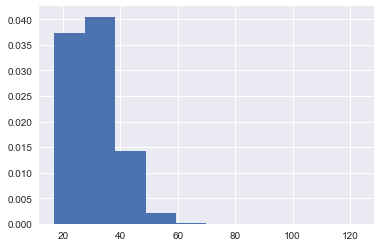

In [9]:
plt.hist(dataset["age"],density=True)

In [10]:
dataset["age"].describe()

count    316200.000000
mean         30.569858
std           8.271802
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max         123.000000
Name: age, dtype: float64

In [11]:
np.sort(dataset["age"].unique())[::-1]

array([123, 111,  79,  77,  73,  72,  70,  69,  68,  67,  66,  65,  64,
        63,  62,  61,  60,  59,  58,  57,  56,  55,  54,  53,  52,  51,
        50,  49,  48,  47,  46,  45,  44,  43,  42,  41,  40,  39,  38,
        37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,  26,  25,
        24,  23,  22,  21,  20,  19,  18,  17])

发现了年龄`123`和`111`，需要清理一下。对于错误数据或者缺失数据有很多种方法，比如缺失位置的数据用整体的平均值代替。如果拿不准的话，直接删除是最安全的做法。

In [12]:
dataset[dataset["age"] > 80]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


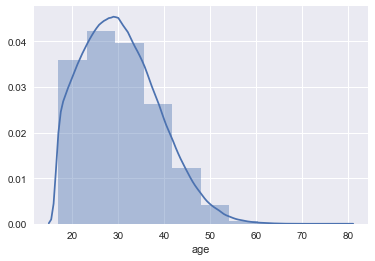

In [13]:
dataset = dataset[dataset.age < 100]
sns.distplot(dataset["age"], bins=10, kde=True)

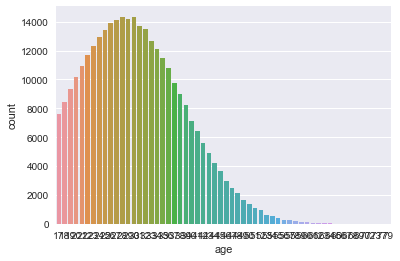

In [14]:
sns.countplot(x='age', data=dataset)

针对每个字段，清洗该字段的数据，并且跟`convertion rate`做个比较

In [15]:
def convertion_rate_by(field):
    return dataset.groupby(field)["converted"].mean().reset_index(name='mean')

In [16]:
convertion_rate_by_age = convertion_rate_by("age")
print(convertion_rate_by_age)

    age      mean
0    17  0.071607
1    18  0.066029
2    19  0.058616
3    20  0.057109
4    21  0.053985
5    22  0.053243
6    23  0.047990
7    24  0.045448
8    25  0.038782
9    26  0.039767
10   27  0.033513
11   28  0.032564
12   29  0.033621
13   30  0.028998
14   31  0.027461
15   32  0.024802
16   33  0.023989
17   34  0.021556
18   35  0.018394
19   36  0.019297
20   37  0.018953
21   38  0.014158
22   39  0.017313
23   40  0.014270
24   41  0.012342
25   42  0.013243
26   43  0.011623
27   44  0.009943
28   45  0.012383
29   46  0.011356
30   47  0.007987
31   48  0.009430
32   49  0.007366
33   50  0.005900
34   51  0.006404
35   52  0.005348
36   53  0.003190
37   54  0.001923
38   55  0.007614
39   56  0.000000
40   57  0.000000
41   58  0.012121
42   59  0.000000
43   60  0.021277
44   61  0.014085
45   62  0.000000
46   63  0.000000
47   64  0.000000
48   65  0.000000
49   66  0.000000
50   67  0.000000
51   68  0.000000
52   69  0.000000
53   70  0.000000
54   72  0

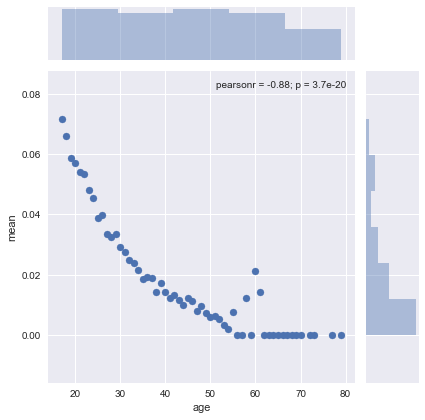

In [17]:
sns.jointplot(x="age", y="mean", data=convertion_rate_by_age)
plt.show()

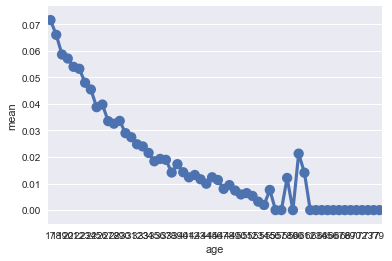

In [18]:
sns.pointplot(x="age", y="mean", data=convertion_rate_by_age)

In [19]:
dataset.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


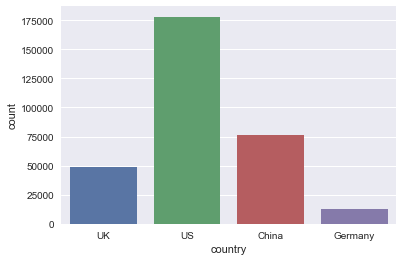

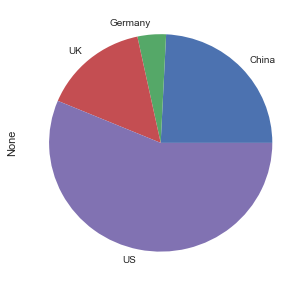

In [20]:
sns.countplot(x="country", data=dataset)
plt.show()
dataset.groupby("country").size().plot.pie(figsize=(5, 5))

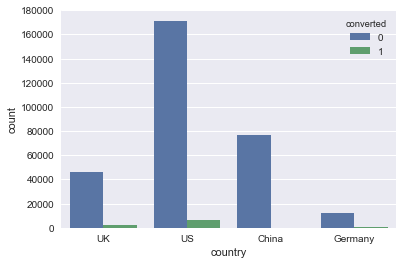

In [21]:
sns.countplot(x="country", hue="converted", data=dataset)

上图显示了每个国家的用户转化数，然而有些信息就是明明摆在面前…有时候就是看不到……<br/>
只看上图，很难发现China的转化比远低于另外三个国家…

   country      mean
0    China  0.001332
1  Germany  0.062428
2       UK  0.052612
3       US  0.037801


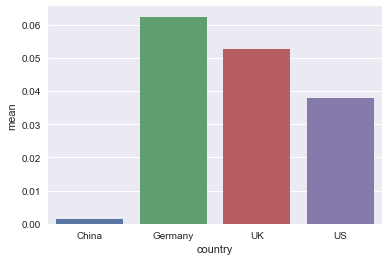

In [22]:
convertion_rate_by_country = convertion_rate_by("country")
print(convertion_rate_by_country)
sns.barplot(x="country", y ="mean", data=convertion_rate_by_country)

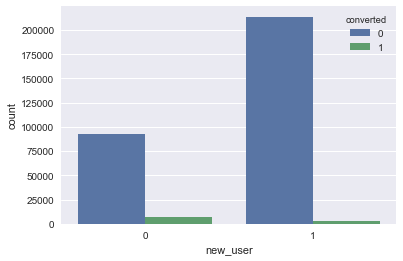

In [23]:
sns.countplot(x="new_user", hue="converted", data=dataset)

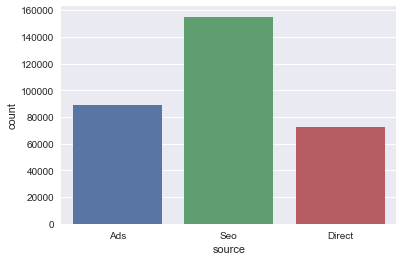

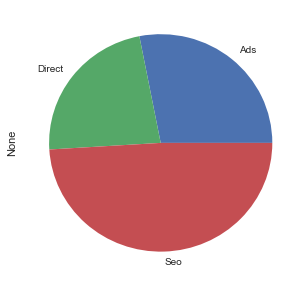

In [24]:
sns.countplot(x="source", data=dataset)
plt.show()
dataset.groupby("source").size().plot.pie(figsize=(5, 5))

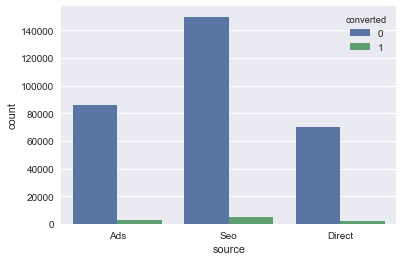

In [25]:
sns.countplot(x="source", hue="converted", data=dataset)

   source      mean
0     Ads  0.034472
1  Direct  0.028169
2     Seo  0.032888


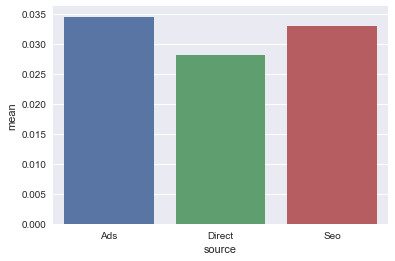

In [26]:
convertion_rate_by_source = convertion_rate_by("source")
print(convertion_rate_by_source)
sns.barplot(x="source", y ="mean", data=convertion_rate_by_source)

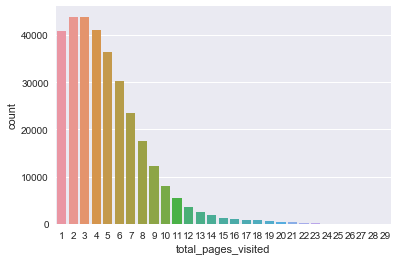

In [27]:
sns.countplot(x='total_pages_visited', data=dataset)

In [28]:
convertion_rate_by_visit = dataset.groupby("total_pages_visited")["converted"].mean().reset_index(name='mean')
print(convertion_rate_by_visit)

    total_pages_visited      mean
0                     1  0.000000
1                     2  0.000228
2                     3  0.000251
3                     4  0.000780
4                     5  0.001570
5                     6  0.003437
6                     7  0.006769
7                     8  0.015238
8                     9  0.033067
9                    10  0.061068
10                   11  0.123471
11                   12  0.244537
12                   13  0.400825
13                   14  0.587521
14                   15  0.740181
15                   16  0.871818
16                   17  0.923077
17                   18  0.961219
18                   19  0.989381
19                   20  0.997531
20                   21  1.000000
21                   22  1.000000
22                   23  1.000000
23                   24  1.000000
24                   25  1.000000
25                   26  1.000000
26                   27  1.000000
27                   28  1.000000
28            

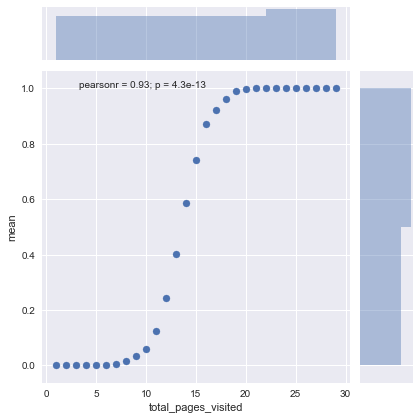

In [29]:
sns.jointplot(x="total_pages_visited", y="mean", data=convertion_rate_by_visit)
plt.show()

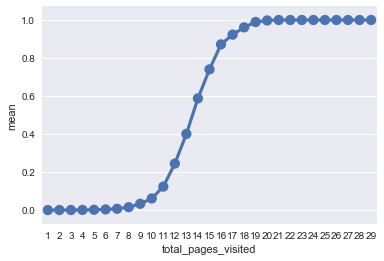

In [30]:
sns.pointplot(x="total_pages_visited", y="mean", data=convertion_rate_by_visit)

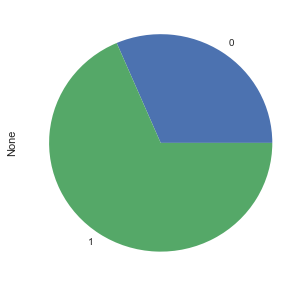

In [31]:
dataset.groupby("new_user").size().plot.pie(figsize=(5, 5))

经过最初步的分析，现在已经可以确定转化率会受到`total visited pages`, `age`, `country (China)`的影响。<br/>
受到`source`影响不大。

### data preprocessing

In [32]:
X = dataset.iloc[:, :-1]
y = dataset["converted"]

In [33]:
X.head()

,country,age,new_user,source,total_pages_visited
0,UK,25,1,Ads,1
1,US,23,1,Seo,5
2,US,28,1,Seo,4
3,China,39,1,Seo,5
4,US,30,1,Seo,6


`country`和`source`字段是`str`, `pandas`会当成`np.object`。<br/>
如果是`R`的话，这里不需要做任何额外操作。但是`scikit-learn`会作为`np.float32`处理，如果保留`np.object`会报错。<br/>
`scikit-learn`里有`LabelEncoder`和`OneHotEncoder`两个类, 处理这种情况。<br/>
**但是实际上`pandas`的`get_dummies()`更方便**

In [34]:
X = pd.get_dummies(X)
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


### machine learning

将数据集分成训练集和测试集

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

使用随机森林模型

In [36]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9843405592931209

In [37]:
rf.oob_score_

0.9843570039461511

正确率在`98.4%`左右，但是baseline是`96.77%`, 所以仅看正确率是不够的.<br>
然而…`DA/BA`的一个误区在于把`analysis`当`kaggle`来做，实际上正确率其实不是最重要的部分。关键在于模型对于数据的**可解释性**。

In [38]:
conversion_rate = y.mean()
baseline = 1 - conversion_rate
print("如果预测所有的converited值为0，正确率为{:.2f}%".format(baseline * 100))

如果预测所有的converited值为0，正确率为96.77%


In [39]:
X_train.columns

Index(['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo'],
      dtype='object')

In [40]:
rf.feature_importances_

array([0.11818734, 0.03779307, 0.80127073, 0.02347724, 0.00277144,
       0.0039331 , 0.0041464 , 0.00271033, 0.00276388, 0.00294646])

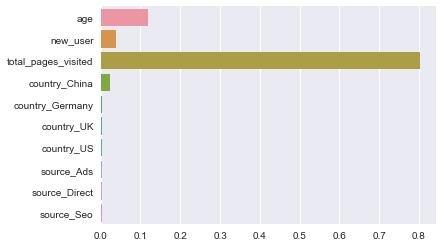

In [41]:
sns.barplot(x = rf.feature_importances_, y = X_train.columns)

显然转化率会受到`total_pages_visited`的影响，然而这个字段本身并不是一个可以调控的属性…<br>
把`total_pages_visited`去掉

In [42]:
X_train = X_train.drop(columns= "total_pages_visited")
X_test = X_test.drop(columns= "total_pages_visited")

In [43]:
rf2 = RandomForestClassifier(n_estimators=100, max_features=3, oob_score=True)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)

In [44]:
accuracy_score(y_test, y_pred)

0.968173193030878

In [45]:
rf2.oob_score_

0.9675339387874554

正确率出现了明显下降

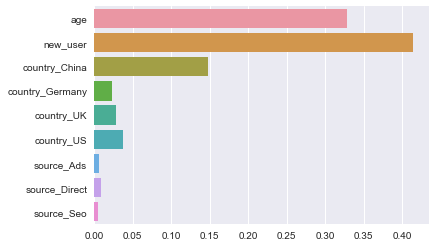

In [46]:
sns.barplot(x = rf2.feature_importances_, y=X_train.columns)

但是模型的可解释性却增强了

今天不写了……未完待续……

### conclusion

1. 该网站对于年轻用户更有吸引力。建议：市场部门针对年轻人扩展广告投放渠道。